In [533]:
import numpy as np
import pandas as pd
import random
import math
import matplotlib as mlt
import matplotlib.pyplot as plt
import plotly
import plotly.graph_objects as go
import seaborn as sns
from IPython.display import Image
from pandas_datareader import data as pdr
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA


import yfinance as yf

import quandl as quandl
quandl.ApiConfig.api_key = 'BzVGriov2pgK4PAYr4sy'

import fredapi
from fredapi import Fred
fred = Fred(api_key='a8fdcaf17f6d0b1df06530fc3a7b1eb7')

%config InlineBackend.figure_format = 'svg'
sns.set_style("darkgrid")

import warnings
warnings.filterwarnings('ignore')

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

pd.set_option('display.max_colwidth', -1)


##### Helper Functions

In [417]:
def cal_perc_missing(df, title = '', rotate_angle = 0, figsize = (10,3)):
    miss_per = pd.DataFrame(df.isnull().sum(axis =0)*100/df.shape[0], columns=['Missing %']).round(2).sort_values(by=['Missing %'], ascending=False)
    display(miss_per.T)
    plt.figure(figsize = figsize)
    plt.xticks(rotation = rotate_angle)
    plt.title(title)
    plt.ylabel('Missing %')
    plt.xlabel('Features')
    _ = plt.bar(x = miss_per.index, height=miss_per['Missing %'], width=0.3)

def z_scaling(df):
    return((df - df.mean())/df.std())

def heatmap(df, annot = True, shape = (10,8)):
    plt.figure(figsize = shape)
    mask = np.triu(df.corr())
    ax = sns.heatmap(df.corr(), annot = annot, vmin=-1, vmax=1, center= 0, cmap= 'coolwarm', fmt='.1g', mask = mask)
    bottom, top = ax.get_ylim()
    ax.set_ylim(bottom + 0.5, top - 0.5)

#### BTC Tech Indicator Data Exploration

In [418]:
quandl.bulkdownload('BCHAIN')
btc_tech_df = pd.read_csv('BCHAIN/BCHAIN_20200913.csv', header= None, names=['name', 'date', 'value'], parse_dates=['date'])
btc_tech_df = btc_tech_df.pivot(index='date', columns='name', values='value')
btc_tech_df.tail()

name        ATRCT     AVBLS  BCDDC  BCDDE  BCDDM  BCDDW  BCDDY          BLCHS  \
date                                                                            
2020-09-10    NaN  1.194565    NaN    NaN    NaN    NaN    NaN  298351.696030   
2020-09-11    NaN  1.333326    NaN    NaN    NaN    NaN    NaN  298529.737255   
2020-09-12    NaN  1.328602    NaN    NaN    NaN    NaN    NaN  298740.422485   
2020-09-13    NaN  1.060539    NaN    NaN    NaN    NaN    NaN  298923.716597   
2020-09-14    NaN       NaN    NaN    NaN    NaN    NaN    NaN            NaN   

name            CPTRA     CPTRV  ...     NTRAN        NTRAT        NTRBL  \
date                             ...                                       
2020-09-10  32.983336  0.702068  ...  314864.0  566471474.0  2113.181208   
2020-09-11  32.782606  0.751036  ...  345981.0  566786901.0  2189.753165   
2020-09-12  31.841403  0.618233  ...  308323.0  567132303.0  2234.224638   
2020-09-13  38.678974  1.373667  ...  300152.0  567440733.0  1765.600000   
2020-09-14        NaN       NaN  ...       NaN          NaN          NaN   

name           NTREP        TOTBC         TOUTV       TRFEE         TRFUS  \
date                                                                        
2020-09-10  310690.0  18484581.25  3.188716e+06   89.195800  9.101633e+05   
2020-09-11  341825.0  18485456.25  3.493320e+06  110.389664  1.140821e+06   
2020-09-12  304149.0  18486337.50  3.130285e+06   95.167103  9.809460e+05   
2020-09-13  296767.0  18487437.50  2.593737e+06   58.115755  6.089183e+05   
2020-09-14       NaN          NaN           NaN         NaN           NaN   

name               TRVOU  TVTVR  
date                             
2020-09-10  1.941569e+08    NaN  
2020-09-11  1.133833e+08    NaN  
2020-09-12  1.470556e+08    NaN  
2020-09-13  1.016532e+08    NaN  
2020-09-14  5.785761e+07    NaN  

[5 rows x 33 columns]

In [459]:
pd.read_excel('Data_Dictionary.xlsx')

Primary Use             Category  \
0   Technical Indicators   Currency Statistics   
1   Technical Indicators   Currency Statistics   
2   Technical Indicators   Currency Statistics   
3   Technical Indicators   Currency Statistics   
4   Technical Indicators   Block Details         
5   Technical Indicators   Block Details         
6   Technical Indicators   Block Details         
7   Technical Indicators   Block Details         
8   Technical Indicators   Block Details         
9   Technical Indicators   Block Details         
10  Technical Indicators   Mining Information    
11  Technical Indicators   Mining Information    
12  Technical Indicators   Mining Information    
13  Technical Indicators   Mining Information    
14  Technical Indicators   Mining Information    
15  Technical Indicators   Mining Information    
16  Technical Indicators   Mining Information    
17  Technical Indicators   Mining Information    
18  Technical Indicators   Network Activity      
19  Technical Indicators   Network Activity      
20  Technical Indicators   Network Activity      
21  Technical Indicators   Network Activity      
22  Technical Indicators   Network Activity      
23  Technical Indicators   Network Activity      
24  Technical Indicators   Network Activity      
25  Technical Indicators   Network Activity      
26  Technical Indicators   Network Activity      
27  Technical Indicators   Network Activity      
28  Technical Indicators   Network Activity      
29  Technical Indicators   Network Activity      
30  Technical Indicators   Market Signals        
31  Technical Indicators   Market Signals        
32  Technical Indicators   Market Signals        

                                       Name   \
0   Total Circulating Bitcoin                  
1   Market Price                               
2   Market Capitalization (USD)                
3   Exchange Trade Volume (USD)                
4   Blockchain Size (MB)                       
5   Average Block Size (MB)                    
6   Average Transactions Per Block             
7   Total Number of Transactions               
8   Median Confirmation Time                   
9   Average Confirmation Time                  
10  Total Hash Rate (TH/s)                     
11  Hashrate Distribution                      
12  Hashrate Distribution Over Time            
13  Network Difficulty                         
14  Miners Revenue (USD)                       
15  Total Transaction Fees (BTC)               
16  Total Transaction Fees (USD)               
17  Fees Per Transaction (USD)                 
18  Unique Addresses Used                      
19  Confirmed Transactions Per Day             
20  Transaction Rate Per Second                
21  Output Value Per Day                       
22  Mempool Transaction Count                  
23  Mempool Size Growth                        
24  Mempool Size (Bytes)                       
25  Mempool Bytes Per Fee Level                
26  Unspent Transaction Outputs                
27  Transactions Excluding Popular Addresses   
28  Estimated Transaction Value (BTC)          
29  Estimated Transaction Value (USD)          
30  Market Value to Realised Value             
31  Network Value to Transactions              
32  Network Value to Transactions Signal       

                                                                                                                                                                               Description  
0    The total number of mined bitcoin that are currently circulating on the network.                                                                                                       
1    The average USD market price across major bitcoin exchanges.                                                                                                                           
2    The total USD value of bitcoin in circulation.                                                              

In [419]:
btc_tech_df.describe().round(3)

name      ATRCT     AVBLS         BCDDC         BCDDE         BCDDM  \
count  3504.000  4272.000  2.756000e+03  2.756000e+03  2.756000e+03   
mean      6.769     0.465  3.831027e+09  4.268389e+06  3.761201e+06   
std       5.216     0.441  3.756570e+09  7.812780e+06  7.657626e+06   
min       0.000     0.000  0.000000e+00  0.000000e+00  0.000000e+00   
25%       0.000     0.020  2.133639e+08  5.299470e+05  3.242160e+05   
50%       7.667     0.295  2.432947e+09  2.530878e+06  1.966104e+06   
75%       9.881     0.909  7.216988e+09  5.004635e+06  4.190439e+06   
max      47.733     1.422  1.177605e+10  1.732980e+08  1.727464e+08   

name          BCDDW         BCDDY       BLCHS     CPTRA         CPTRV  ...  \
count  2.756000e+03  2.756000e+03    4272.000  4272.000  4.272000e+03  ...   
mean   4.064165e+06  1.874889e+06   73427.366    21.227  1.479691e+04  ...   
std    7.753399e+06  6.447294e+06   90463.723    25.645  6.418160e+05  ...   
min    0.000000e+00  0.000000e+00       0.000     0.000  0.000000e+00  ...   
25%    4.688145e+05  0.000000e+00     547.250     3.634  1.034000e+00  ...   
50%    2.287534e+06  4.491245e+05   23993.000     9.049  1.817000e+00  ...   
75%    4.696996e+06  1.683390e+06  136140.204    33.386  4.482000e+00  ...   
max    1.730718e+08  1.702367e+08  298923.717   161.686  3.650000e+07  ...   

name        NTRAN         NTRAT     NTRBL       NTREP         TOTBC  \
count    4272.000  4.272000e+03  4272.000    4272.000  4.271000e+03   
mean   132937.075  1.407466e+08   890.802  125317.166  1.185453e+07   
std    124944.800  1.709468e+08   848.739  123204.808  5.596292e+06   
min         0.000  1.000000e+00     1.000       0.000  5.000000e+01   
25%      6986.000  1.988054e+06    48.000    5884.500  7.821325e+06   
50%     81567.000  5.094556e+07   540.000   75476.500  1.347862e+07   
75%    246268.250  2.611732e+08  1680.967  239588.250  1.661688e+07   
max    490644.000  5.674407e+08  2762.541  470650.000  1.848744e+07   

name          TOUTV     TRFEE         TRFUS         TRVOU     TVTVR  
count  4.272000e+03  4272.000  4.272000e+03  4.273000e+03  2753.000  
mean   1.339027e+06    51.833  2.729317e+05  1.134578e+08    12.195  
std    1.995179e+06   100.547  1.157109e+06  2.958240e+08    19.227  
min    0.000000e+00     0.000  0.000000e+00  0.000000e+00     0.000  
25%    4.479261e+05     7.151  4.401600e+01  2.309887e+05     1.166  
50%    9.846578e+05    21.743  6.247208e+03  6.157878e+06     5.427  
75%    1.715991e+06    46.547  1.411571e+05  9.717566e+07    14.338  
max    4.599222e+07  1495.946  2.272484e+07  5.352016e+09   224.065  

[8 rows x 33 columns]

name       MIOPM  TVTVR  NETDF  BCDDC  BCDDE  BCDDM  BCDDW  BCDDY  ATRCT  \
Missing %   36.3  35.57  35.57   35.5   35.5   35.5   35.5   35.5   18.0   

name       MWNTD  ...  BLCHS  DIFF  MKTCP  AVBLS  MIREV  CPTRA  ETRVU  ETRAV  \
Missing %   0.87  ...   0.02  0.02   0.02   0.02   0.02   0.02   0.02   0.02   

name       TRVOU  MKPRU  
Missing %    0.0    0.0  

[1 rows x 33 columns]

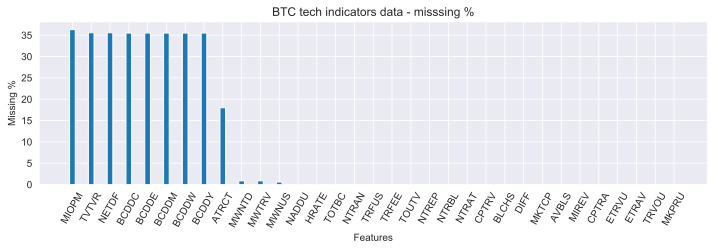

In [420]:
cal_perc_missing(btc_tech_df, rotate_angle=60, figsize=(12,3), title='BTC tech indicators data - misssing %')

In [421]:
## Normalizing the data after taking log of all values 
temp = np.log(df)
temp = temp.replace([np.inf, -np.inf], 0)
df_normalized = z_scaling(temp)
df_normalized.head()

name           ATRCT     AVBLS     BCDDC     BCDDE     BCDDM     BCDDW  \
date                                                                     
2009-01-03 -1.474559 -1.986513 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-04 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-05 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-06 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   
2009-01-07 -1.474559  0.817103 -5.537607 -2.702035 -2.184484 -2.441472   

name          BCDDY     BLCHS     CPTRA     CPTRV  ...     NTRAN     NTRAT  \
date                                               ...                       
2009-01-03 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-04 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-05 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-06 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   
2009-01-07 -1.48335 -1.912153 -1.598156 -0.643029  ... -3.755484 -4.811874   

name           NTRBL     NTREP      TOTBC     TOUTV     TRFEE     TRFUS  \
date                                                                      
2009-01-03 -1.985545 -3.708772 -11.190956 -4.672718 -1.348808 -1.501352   
2009-01-04 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-05 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-06 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   
2009-01-07 -1.985545 -3.708772 -11.190956 -6.646487 -1.348808 -1.501352   

name           TRVOU     TVTVR  
date                            
2009-01-03 -2.172229 -1.241183  
2009-01-04 -2.172229 -1.241183  
2009-01-05 -2.172229 -1.241183  
2009-01-06 -2.172229 -1.241183  
2009-01-07 -2.172229 -1.241183  

[5 rows x 33 columns]

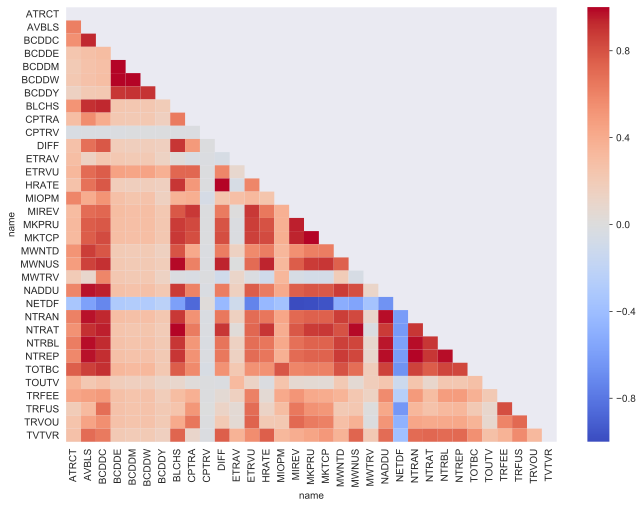

In [422]:
heatmap(btc_tech_df, shape = (11,8), annot=False)

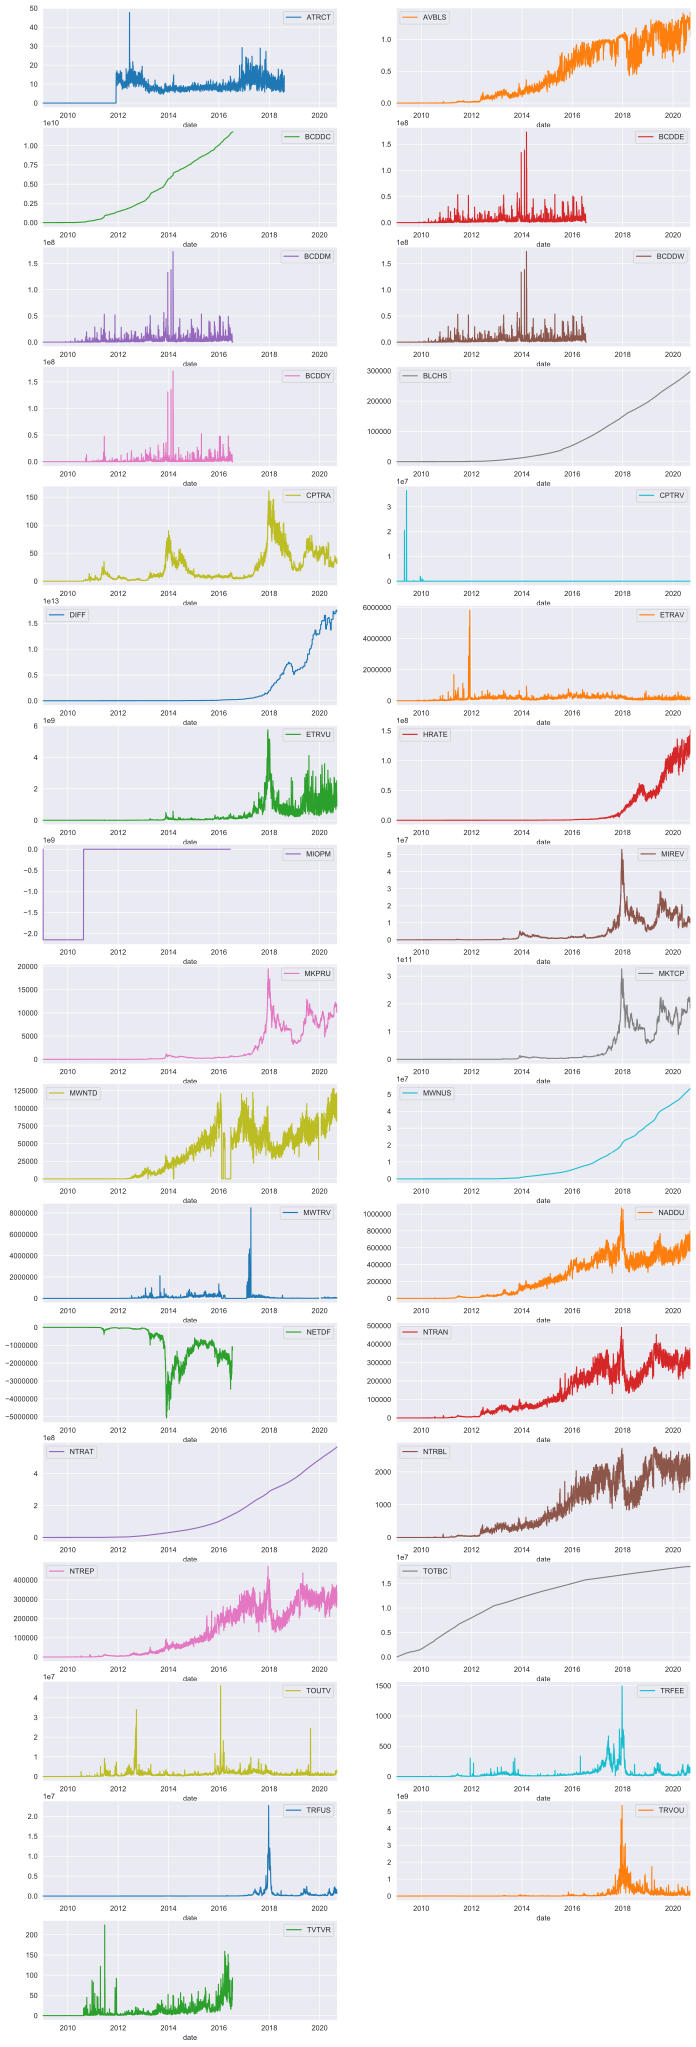

In [423]:
temp = btc_tech_df
x = math.ceil(temp.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

In [513]:
btc_tech_df
miss_per = pd.DataFrame(df.isnull().sum(axis =0)*100/df.shape[0], columns=['Missing %']).round(2).sort_values(by=['Missing %'], ascending=False)
btc_tech_clean_df = btc_tech_df[list(set(btc_tech_df.columns)-set(miss_per[miss_per['Missing %'] >1].index))].ffill(axis = 0)
btc_tech_clean_df = btc_tech_clean_df.bfill(axis =0)
btc_tech_clean_df = btc_tech_clean_df.drop(columns=['MKPRU'])
btc_tech_clean_df

name           NTRAN         ETRVU         TRFUS     NTREP         TOUTV  \
date                                                                       
2009-01-03  1.0       0.000000e+00  0.000000e+00  1.0       5.000000e+01   
2009-01-04  0.0       0.000000e+00  0.000000e+00  0.0       0.000000e+00   
2009-01-05  0.0       0.000000e+00  0.000000e+00  0.0       0.000000e+00   
2009-01-06  0.0       0.000000e+00  0.000000e+00  0.0       0.000000e+00   
2009-01-07  0.0       0.000000e+00  0.000000e+00  0.0       0.000000e+00   
...         ...                ...           ...  ...                ...   
2020-09-10  314864.0  1.479240e+09  9.101633e+05  310690.0  3.188716e+06   
2020-09-11  345981.0  1.510201e+09  1.140821e+06  341825.0  3.493320e+06   
2020-09-12  308323.0  1.615058e+09  9.809460e+05  304149.0  3.130285e+06   
2020-09-13  300152.0  8.558094e+08  6.089183e+05  296767.0  2.593737e+06   
2020-09-14  300152.0  8.558094e+08  6.089183e+05  296767.0  2.593737e+06   

name               MWTRV         TRVOU     CPTRV        NTRAT      CPTRA  ...  \
date                                                                      ...   
2009-01-03  0.000000      0.000000e+00  0.000000  1.0          0.000000   ...   
2009-01-04  0.000000      0.000000e+00  0.000000  1.0          0.000000   ...   
2009-01-05  0.000000      0.000000e+00  0.000000  1.0          0.000000   ...   
2009-01-06  0.000000      0.000000e+00  0.000000  1.0          0.000000   ...   
2009-01-07  0.000000      0.000000e+00  0.000000  1.0          0.000000   ...   
...              ...               ...       ...  ...               ...   ...   
2020-09-10  77234.328019  1.941569e+08  0.702068  566471474.0  32.983336  ...   
2020-09-11  49051.081749  1.133833e+08  0.751036  566786901.0  32.782606  ...   
2020-09-12  50196.690114  1.470556e+08  0.618233  567132303.0  31.841403  ...   
2020-09-13  50196.690114  1.016532e+08  1.373667  567440733.0  38.678974  ...   
2020-09-14  50196.690114  5.785761e+07  1.373667  567440733.0  38.678974  ...   

name             MWNUS     MWNTD     NADDU         MKTCP       TRFEE  \
date                                                                   
2009-01-03  2.0         0.0       1.0       0.000000e+00  0.000000     
2009-01-04  2.0         0.0       0.0       0.000000e+00  0.000000     
2009-01-05  2.0         0.0       0.0       0.000000e+00  0.000000     
2009-01-06  2.0         0.0       0.0       0.000000e+00  0.000000     
2009-01-07  2.0         0.0       0.0       0.000000e+00  0.000000     
...         ...         ...       ...                ...       ...     
2020-09-10  53486559.0  118126.0  681429.0  1.889864e+11  89.195800    
2020-09-11  53524205.0  117547.0  745318.0  1.905111e+11  110.389664   
2020-09-12  53550666.0  114355.0  677215.0  1.908644e+11  95.167103    
2020-09-13  53587633.0  114355.0  604531.0  1.927223e+11  58.115755    
2020-09-14  53587633.0  114355.0  604531.0  1.927223e+11  58.115755    

name                DIFF         MIREV          BLCHS        TOTBC  \
date                                                                 
2009-01-03  1.000000e+00  0.000000e+00  0.000000       50.00         
2009-01-04  0.000000e+00  0.000000e+00  0.000000       50.00         
2009-01-05  0.000000e+00  0.000000e+00  0.000000       50.00         
2009-01-06  0.000000e+00  0.000000e+00  0.000000       50.00         
2009-01-07  0.000000e+00  0.000000e+00  0.000000       50.00         
...                  ...           ...       ...         ...         
2020-09-10  1.734600e+13  1.038527e+07  298351.696030  18484581.25   
2020-09-11  1.734600e+13  1.134216e+07  298529.737255  18485456.25   
2020-09-12  1.734600e+13  9.984827e+06  298740.422485  18486337.50   
2020-09-13  1.734600e+13  1.175597e+07  298923.716597  18487437.50   
2020-09-14  1.734600e+13  1.175597e+07  298923.716597  18487437.50   

name              NTRBL  
date                     
2009-01-03  1.000000     
2009-01-04  1.000000     
2009-

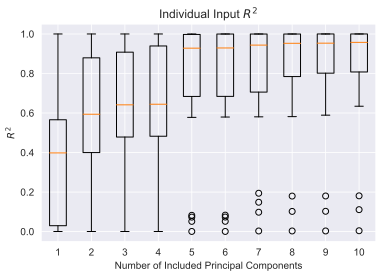

In [522]:
import statsmodels.api as sm
from statsmodels.multivariate.pca import PCA

pca_model = PCA(btc_tech_clean_df, standardize=False, demean=True)
pca_model.plot_rsquare();

#### Global Stock Data Exploration

In [424]:
## Equity index data
## sp500
## nikkie 255
## volatility sp500 index
## dax index
## uk 100 index
## shanghai composite index

start_date = "2010-05-31"

sp500 = yf.Ticker('^GSPC')
sp500 = sp500.history(start = start_date)

ni255 = yf.Ticker('^N225')
ni255 = ni255.history(start = start_date)

dax = yf.Ticker('^GDAXI')
dax = dax.history(start = start_date)

sha = yf.Ticker('000001.SS')
sha = sha.history(start = start_date)

ukx = yf.Ticker('^FTSE')
ukx = ukx.history(start = start_date)

vix = yf.Ticker('^Vix')
vix = vix.history(start = start_date)

stock_index = pd.concat([sp500['Close'], ni255['Close'], dax['Close'], sha['Close'], ukx['Close'], vix['Close']], axis = 1)
stock_index.columns = ['sp500', 'ni255', 'dax', 'sha', 'ukx', 'vix']
stock_index.head()

sp500    ni255      dax      sha     ukx    vix
Date                                                         
2010-05-31      NaN  9768.70  5964.33  2592.15     NaN    NaN
2010-06-01  1070.71  9711.83  5981.27  2568.28  5163.3  35.54
2010-06-02  1098.38  9603.24  5981.20  2571.42  5151.3  30.17
2010-06-03  1102.83  9914.19  6054.63  2552.66  5211.2  29.46
2010-06-04  1064.88  9901.19  5938.88  2553.59  5126.0  35.48

In [425]:
stock_index.describe()

sp500         ni255           dax          sha          ukx  \
count  2594.000000   2525.000000   2611.000000  2506.000000  2599.000000   
mean   2073.485393  16401.982238   9853.415059  2809.147845  6542.504963   
std     625.884841   4988.459084   2341.360878   527.098437   697.067553   
min    1022.580000   8160.010000   5072.330000  1950.010000  4805.800000   
25%    1460.915000  10609.640000   7529.280000  2356.557500  5945.550000   
50%    2056.325000  16974.450000  10009.080000  2862.600000  6605.300000   
75%    2635.887500  20690.710000  12004.080000  3135.060000  7164.250000   
max    3580.840000  24270.620000  13789.000000  5166.350000  7877.500000   

               vix  
count  2594.000000  
mean     17.618084  
std       7.390910  
min       9.140000  
25%      13.100000  
50%      15.525000  
75%      19.497500  
max      82.690000

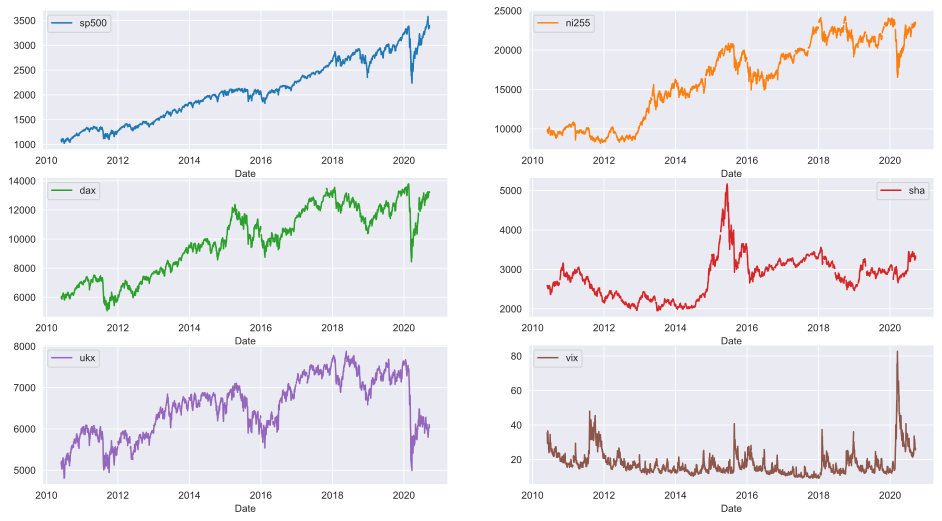

In [426]:
temp = stock_index
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

sha  ni255  sp500   vix   ukx   dax
Missing %  6.6   5.89   3.32  3.32  3.13  2.68

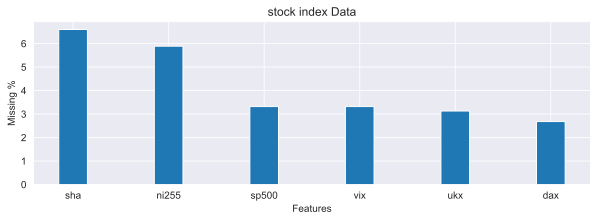

In [427]:
cal_perc_missing(stock_index, title='stock index Data')

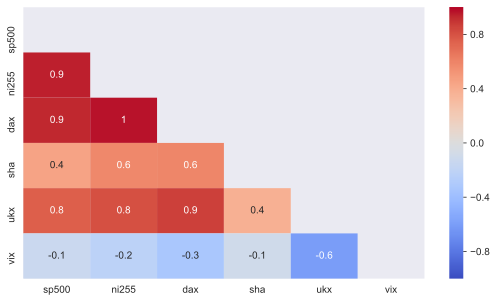

In [428]:
heatmap(stock_index, shape = (9,5), annot=True)

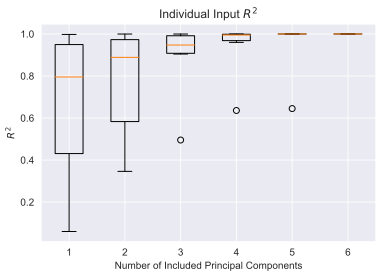

In [531]:
pca_model = PCA(stock_index.ffill(axis=0).bfill(axis=0), standardize=False, demean=True)
pca_model.plot_rsquare();

#### Currency Data Exploration

In [429]:
eurusd = yf.Ticker('EURUSD=X')
eurusd = eurusd.history(start = start_date)

usdjpy = yf.Ticker('USDJPY=X')
usdjpy = usdjpy.history(start = start_date)

audusd = yf.Ticker('AUDUSD=X')
audusd = audusd.history(start = start_date)

usdcad = yf.Ticker('USDCAD=X')
usdcad = usdcad.history(start = start_date)

gbpusd = yf.Ticker('GBPUSD=X')
gbpusd = gbpusd.history(start = start_date)

nzdusd = yf.Ticker('NZDUSD=X')
nzdusd = nzdusd.history(start = start_date)

gbpjpy = yf.Ticker('GBPJPY=X')
gbpjpy = gbpjpy.history(start = start_date)

eurjpy = yf.Ticker('EURJPY=X')
eurjpy = eurjpy.history(start = start_date)

audjpy = yf.Ticker('AUDJPY=X')
audjpy = audjpy.history(start = start_date)

usdchf = yf.Ticker('USDCHF=X')
usdchf = usdchf.history(start = start_date)

euraud = yf.Ticker('EURAUD=X')
euraud = euraud.history(start = start_date)

currency = pd.concat([eurusd['Close'], usdjpy['Close'], audusd['Close'], usdcad['Close'], gbpusd['Close'],
                      nzdusd['Close'], gbpjpy['Close'], eurjpy['Close'], audjpy['Close'], usdchf['Close'],
                      euraud['Close']], axis = 1)

currency.columns = ['eur_usd', 'usd_jpy', 'aud_usd', 'usd_cad', 'gbp_usd', 'nzd_usd', 'gbp_jpy', 'eur_jpy', 'aud_jpy',
                       'usd_chf', 'eur_aud']

currency.head()

eur_usd  usd_jpy  aud_usd  usd_cad  gbp_usd  nzd_usd  gbp_jpy  \
Date                                                                        
2010-05-31   1.2288   91.190   0.8466   1.0431   1.4522   0.6812  132.400   
2010-06-01   1.2233   91.100   0.8332   1.0538   1.4667   0.6772  133.582   
2010-06-02   1.2239   92.190   0.8418   1.0388   1.4650   0.6805  135.049   
2010-06-03   1.2169   92.623   0.8434   1.0403   1.4634   0.6838  135.513   
2010-06-04   1.1971   91.880   0.8242   1.0615   1.4458   0.6710  132.770   

            eur_jpy  aud_jpy  usd_chf  eur_aud  
Date                                            
2010-05-31  112.050  77.1715   1.1563   1.4511  
2010-06-01  111.430  75.8100   1.1555   1.4682  
2010-06-02  112.820  77.5795   1.1552   1.4535  
2010-06-03  112.691  78.0990   1.1561   1.4425  
2010-06-04  109.960  75.6990   1.1621   1.4523

In [460]:
currency[currency.isna == True]

KeyError: False

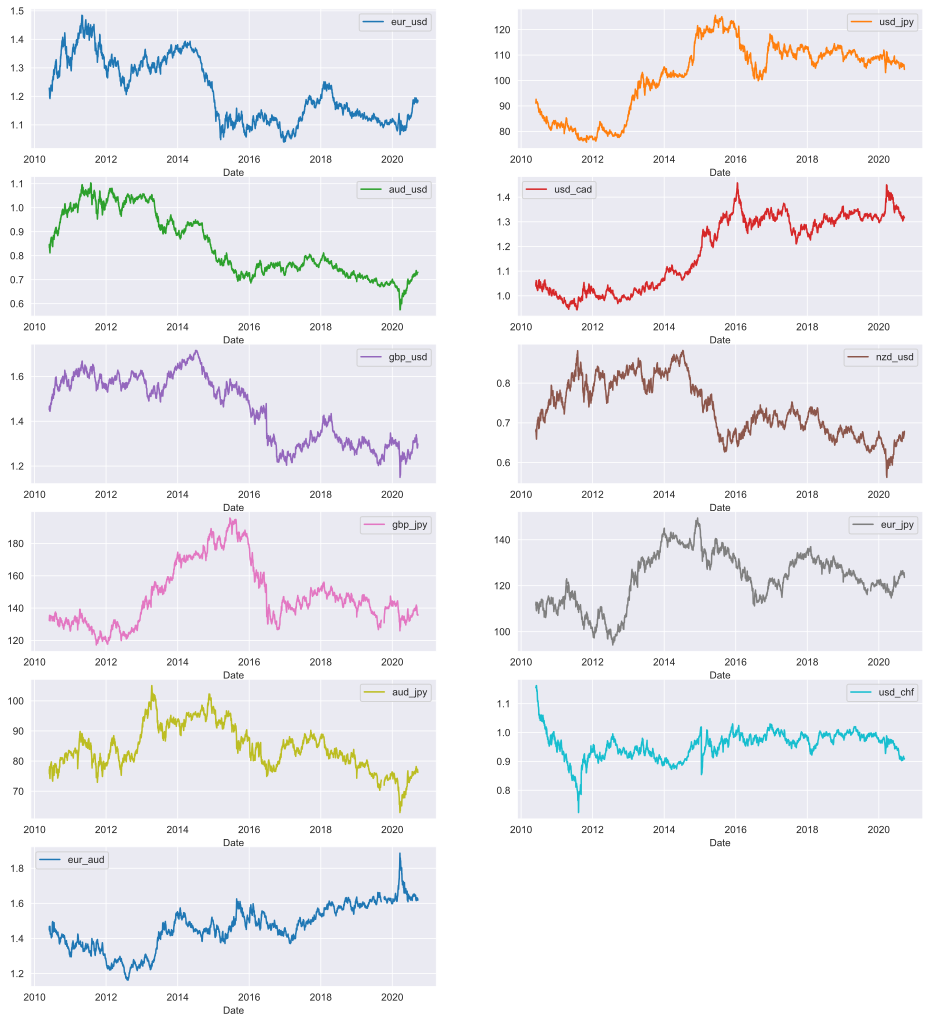

In [430]:
temp = currency
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

In [431]:
currency.describe()

eur_usd      usd_jpy      aud_usd      usd_cad      gbp_usd  \
count  2685.000000  2685.000000  2684.000000  2684.000000  2685.000000   
mean      1.218715   102.048175     0.842020     1.186154     1.456809   
std       0.111796    13.790262     0.133381     0.146805     0.148495   
min       1.039000    75.740000     0.574300     0.943200     1.149400   
25%       1.119800    89.600000     0.727600     1.027850     1.304500   
50%       1.185600   106.822000     0.782800     1.250350     1.511300   
75%       1.319100   111.532000     0.971875     1.318425     1.585500   
max       1.484400   125.629000     1.103500     1.457800     1.716100   

           nzd_usd      gbp_jpy      eur_jpy      aud_jpy      usd_chf  \
count  2685.000000  2666.000000  2667.000000  2668.000000  2682.000000   
mean      0.737505   147.690625   123.229981    84.448382     0.956294   
std       0.070424    19.039198    11.628541     7.424785     0.047470   
min       0.562600   117.180000    94.210000    62.918000     0.722800   
25%       0.677200   132.775750   114.788000    79.192250     0.927200   
50%       0.728300   143.297500   124.135000    83.405000     0.964300   
75%       0.801900   157.610000   132.076000    89.601250     0.989100   
max       0.882400   195.742000   149.441000   105.059000     1.162700   

           eur_aud  
count  2667.000000  
mean      1.463215  
std       0.125363  
min       1.162500  
25%       1.382000  
50%       1.467400  
75%       1.566900  
max       1.886000

gbp_jpy  eur_jpy  eur_aud  aud_jpy  usd_chf  aud_usd  usd_cad  \
Missing %     0.86     0.82     0.82     0.78     0.26     0.19     0.19   

           eur_usd  usd_jpy  gbp_usd  nzd_usd  
Missing %     0.15     0.15     0.15     0.15

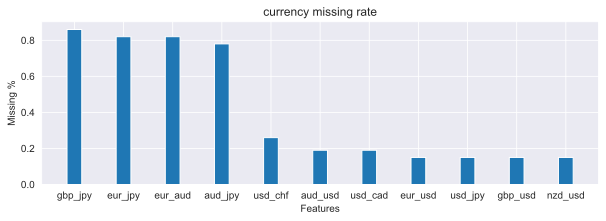

In [432]:
cal_perc_missing(currency, title='currency missing rate')

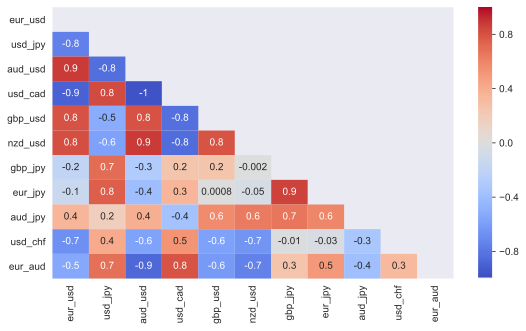

In [433]:
heatmap(currency, shape = (9,5), annot=True)

TypeError: 'NoneType' object is not callable

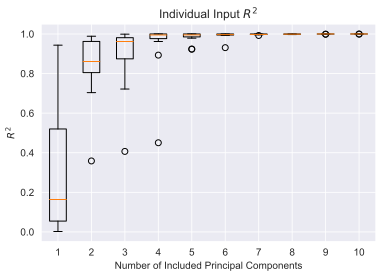

In [536]:
pca_model = PCA(currency.ffill(axis=0).bfill(axis=0), standardize=False, demean=True)
plt = pca_model.plot_rsquare();

##### Alt Crypto- Currency Data Exploration

In [434]:
## Top 10 cryptocurrency
# Ethereum (ETH) $19.4bn
# XRP (XRP) $8.22bn
# Tether (USDT) $6.4bn
# Bitcoin Cash (BCH) $4.1bn
# Litecoin (LTC) $2.6bn
# EOS (EOS) $2.4bn
# Binance Coin (BNB) $2.4bn
# dogecoin

xrp = yf.Ticker('XRP-USD')
xrp = xrp.history(start = start_date)

usdt = yf.Ticker('USDT-USD')
usdt = usdt.history(start = start_date)

bch = yf.Ticker('BCH-USD')
bch = bch.history(start = start_date)

ltc = yf.Ticker('LTC-USD')
ltc = ltc.history(start = start_date)

eos = yf.Ticker('EOS-USD')
eos = eos.history(start = start_date)

bnb = yf.Ticker('BNB-USD')
bnb = bnb.history(start = start_date)

doge = yf.Ticker('DOGE-USD')
doge = doge.history(start = start_date)

eos = yf.Ticker('EOS-USD')
eos = eos.history(start = start_date)

zec = yf.Ticker('ZEC-USD')
zec = zec.history(start = start_date)

crypto_df = pd.concat([eth['Close'], xrp['Close'], usdt['Close'], bch['Close'], 
                    ltc['Close'], eos['Close'], bnb['Close'], doge['Close'], 
                    eos['Close'], zec['Close']], axis = 1)
crypto_df.columns = ['eth', 'xrp', 'usdt', 'bch', 'ltc', 'eoc', 'bnb', 'doge', 'eos', 'zec']

crypto_df

eth     xrp    usdt     bch    ltc     eoc    bnb    doge  \
Date                                                                       
2014-09-17     NaN  0.0054     NaN     NaN   5.06     NaN    NaN  0.0003   
2014-09-18     NaN  0.0051     NaN     NaN   4.69     NaN    NaN  0.0003   
2014-09-19     NaN  0.0049     NaN     NaN   4.33     NaN    NaN  0.0003   
2014-09-20     NaN  0.0048     NaN     NaN   4.29     NaN    NaN  0.0003   
2014-09-21     NaN  0.0046     NaN     NaN   4.25     NaN    NaN  0.0003   
...            ...     ...     ...     ...    ...     ...    ...     ...   
2020-09-14  377.27  0.2463  1.0013  226.26  49.09  2.7385  31.18  0.0028   
2020-09-15  364.84  0.2438  1.0025  235.63  48.39  2.7106  27.20  0.0028   
2020-09-16  366.54  0.2478  1.0034  231.77  47.93  2.7197  27.96  0.0028   
2020-09-17     NaN  0.2522  1.0019  233.17  48.88  2.7324  26.99  0.0028   
2020-09-18     NaN  0.2546  1.0036  237.65  48.99  2.7450  28.58  0.0028   

               eos    zec  
Date                       
2014-09-17     NaN    NaN  
2014-09-18     NaN    NaN  
2014-09-19     NaN    NaN  
2014-09-20     NaN    NaN  
2014-09-21     NaN    NaN  
...            ...    ...  
2020-09-14  2.7385  63.32  
2020-09-15  2.7106  59.50  
2020-09-16  2.7197  58.46  
2020-09-17  2.7324  59.60  
2020-09-18  2.7450  59.61  

[2193 rows x 10 columns]

In [435]:
crypto_df.describe()

eth          xrp         usdt          bch          ltc  \
count  1867.000000  2193.000000  2027.000000  1153.000000  2193.000000   
mean    208.823460     0.225866     1.000805   543.369696    44.826416   
std     228.212731     0.318138     0.016654   523.241588    53.463211   
min       0.430000     0.004100     0.606200    77.370000     1.160000   
25%      12.060000     0.007700     1.000000   234.240000     3.780000   
50%     171.640000     0.193600     1.000000   329.240000    38.920000   
75%     284.165000     0.309900     1.002800   622.170000    60.620000   
max    1396.420000     3.377800     1.211100  3923.070000   358.340000   

               eoc          bnb         doge          eos          zec  
count  1175.000000  1151.000000  2193.000000  1175.000000  1420.000000  
mean      4.730059    14.297281     0.001796     4.730059   142.178732  
std       3.358351     8.216743     0.001900     3.358351   151.009032  
min       0.493200     0.100000     0.000100     0.493200    24.500000  
25%       2.606150     9.375000     0.000200     2.606150    50.815000  
50%       3.633500    14.180000     0.001800     3.633500    72.430000  
75%       5.876550    18.710000     0.002700     5.876550   206.210000  
max      21.542600    38.820000     0.017100    21.542600  2044.470000

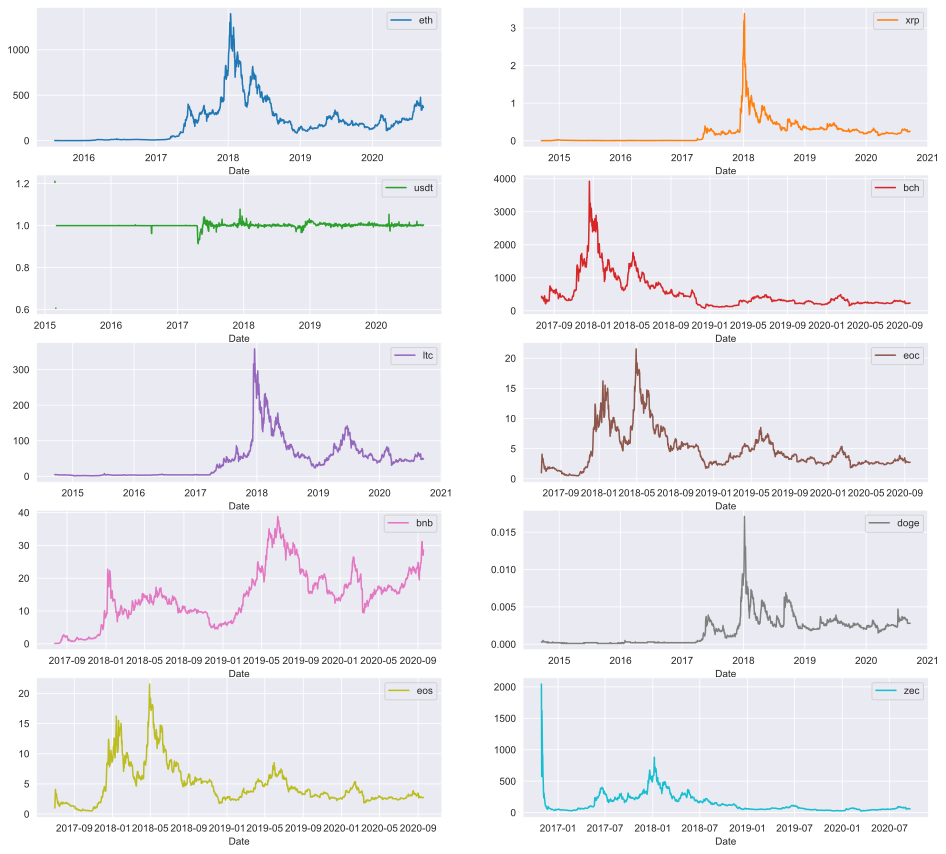

In [436]:
temp = crypto_df
x = math.ceil(currency.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

bnb    bch    eoc    eos    zec    eth  usdt  xrp  ltc  doge
Missing %  47.51  47.42  46.42  46.42  35.25  14.87  7.57  0.0  0.0   0.0

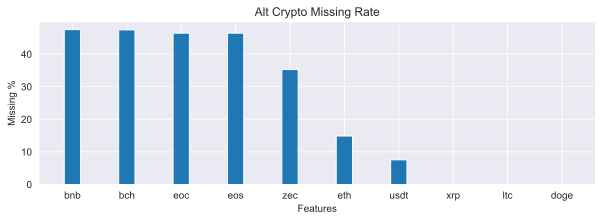

In [437]:
cal_perc_missing(crypto_df, title='Alt Crypto Missing Rate')

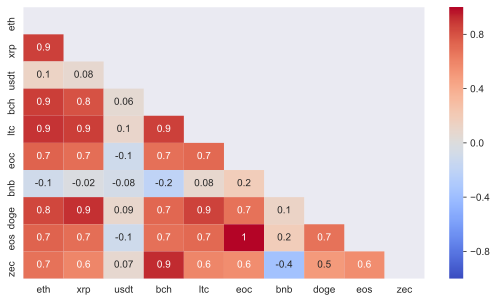

In [438]:
heatmap(crypto_df, shape = (9,5), annot=True)

##### Treasury Data Exploration

In [439]:
treasury_df = pd.read_excel('Term Structure 1990_2020.xlsx', parse_dates=['Dates'])
treasury_df.index = treasury_df['Dates']
treasury_df = treasury_df.drop(columns=['Dates'])
treasury_df

1 Month  2 Months  3 Months  6 Months  1 Year  2 Years  3 Years  \
Dates                                                                         
2020-09-08    0.090     0.099     0.114     0.120   0.133    0.143    0.166   
2020-09-07    0.089     0.104     0.107     0.118   0.124    0.145    0.176   
2020-09-04    0.089     0.104     0.107     0.118   0.124    0.145    0.176   
2020-09-03    0.089     0.098     0.103     0.114   0.118    0.128    0.145   
2020-09-02    0.091     0.096     0.104     0.114   0.118    0.134    0.150   
...             ...       ...       ...       ...     ...      ...      ...   
1990-01-05    6.750       NaN     7.781     7.836   7.798    7.885    7.918   
1990-01-04    6.980       NaN     7.828     7.885   7.813    7.910    7.930   
1990-01-03    6.770       NaN     7.861     7.920   7.825    7.927    7.936   
1990-01-02    6.980       NaN     7.809     7.888   7.793    7.875    7.880   
1990-01-01    6.200       NaN     7.779     7.857   7.817    7.841    7.868   

            5 Years  7 Years  10 Years  20 Years  30 Years  
Dates                                                       
2020-09-08    0.268    0.465     0.680     1.213     1.423  
2020-09-07    0.300    0.503     0.719     1.258     1.473  
2020-09-04    0.300    0.503     0.719     1.258     1.473  
2020-09-03    0.249    0.438     0.636     1.150     1.363  
2020-09-02    0.252    0.451     0.649     1.157     1.380  
...             ...      ...       ...       ...       ...  
1990-01-05    7.896      NaN     7.984       NaN     8.056  
1990-01-04    7.900      NaN     7.972       NaN     8.035  
1990-01-03    7.911      NaN     7.974       NaN     8.034  
1990-01-02    7.847      NaN     7.930       NaN     7.990  
1990-01-01    7.832      NaN     7.935       NaN     7.978  

[8007 rows x 12 columns]

In [440]:
treasury_df.describe()

1 Month    2 Months     3 Months     6 Months       1 Year  \
count  8007.00000  496.000000  8007.000000  8007.000000  8007.000000   
mean      2.55724    1.536522     2.712958     2.845671     3.056602   
std       2.17433    0.915872     2.282984     2.317644     2.226586   
min      -0.09400   -0.124000    -0.088000     0.004000     0.064000   
25%       0.16550    0.224500     0.231000     0.402500     0.542000   
50%       2.22500    1.852000     2.338000     2.447000     3.344000   
75%       4.66500    2.352250     4.973000     5.091500     4.979000   
max       8.20000    2.467000     8.243000     8.491000     8.632000   

           2 Years      3 Years      5 Years      7 Years     10 Years  \
count  8007.000000  8007.000000  8007.000000  3009.000000  8007.000000   
mean      3.266500     3.500537     3.875408     2.031221     4.417780   
std       2.338692     2.281717     2.176052     0.664005     1.979131   
min       0.107000     0.113000     0.191000     0.359000     0.508000   
25%       0.932000     1.364000     1.817500     1.550000     2.637000   
50%       2.933000     3.235000     3.741000     2.049000     4.310000   
75%       5.356500     5.488000     5.711500     2.482000     5.935000   
max       9.032000     9.083000     9.066000     3.583000     9.062000   

        20 Years     30 Years  
count  79.000000  8007.000000  
mean    1.163873     4.959798  
std     0.104403     1.788043  
min     0.956000     0.997000  
25%     1.095000     3.259000  
50%     1.176000     4.844000  
75%     1.218500     6.201500  
max     1.451000     9.172000

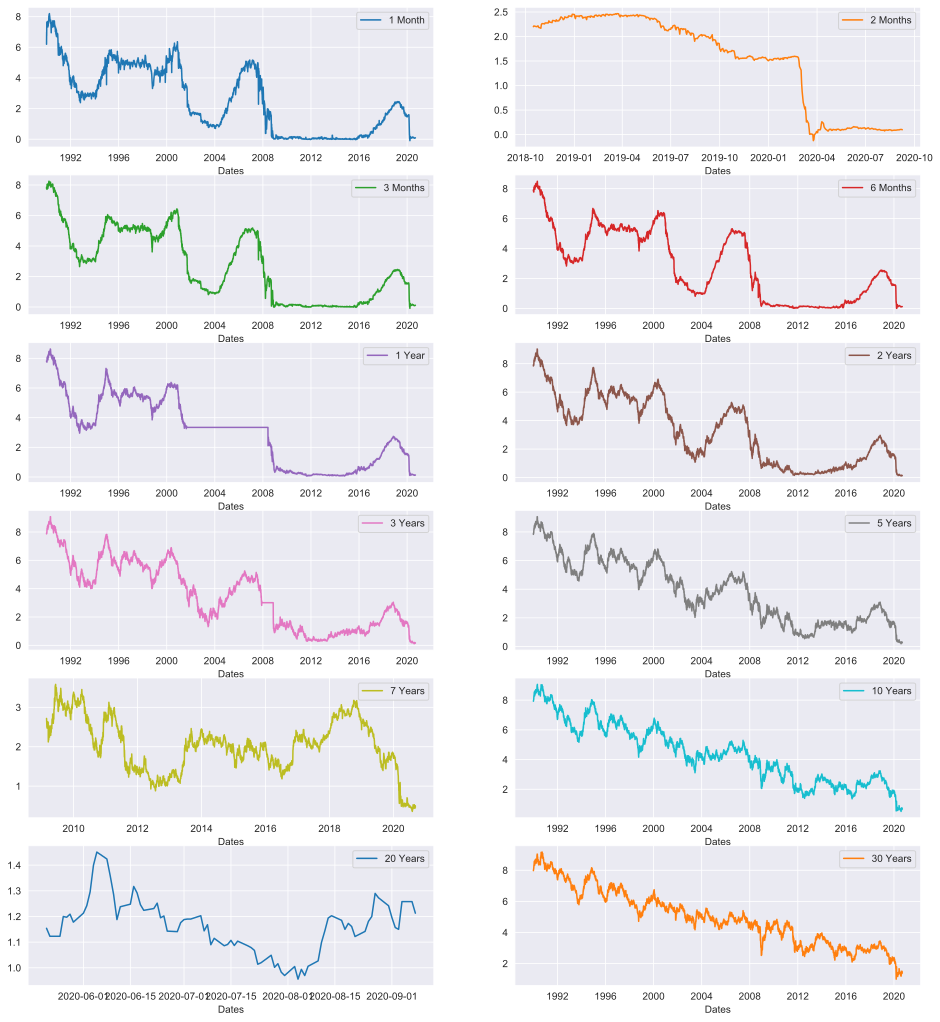

In [441]:
temp = treasury_df
x = math.ceil(temp.shape[1]/2)
temp.plot(figsize = (16,3*x), subplots = True, sharex = False, layout=(x,2));

20 Years  2 Months  7 Years  1 Month  3 Months  6 Months  1 Year  \
Missing %     99.01     93.81    62.42      0.0       0.0       0.0     0.0   

           2 Years  3 Years  5 Years  10 Years  30 Years  
Missing %      0.0      0.0      0.0       0.0       0.0

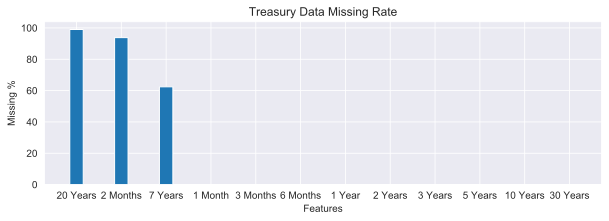

In [442]:
cal_perc_missing(treasury_df, title='Treasury Data Missing Rate')

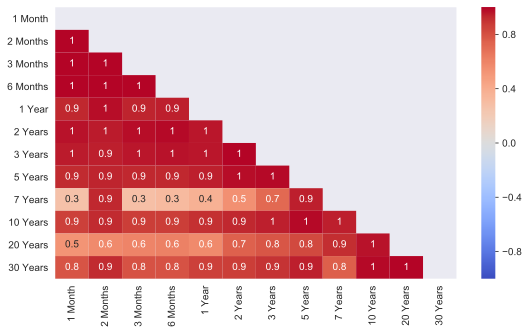

In [443]:
heatmap(treasury_df, shape = (9,5), annot=True)

#### Economic and Commodity Data Exploration

In [444]:
start_date="2010-01-01"
end_date="2020-06-30"
bitcoin = quandl.get("BCHAIN/MKPRU", start_date=start_date, end_date=end_date)
gold = quandl.get("CHRIS/CME_GC1", start_date=start_date, end_date=end_date)
silver = quandl.get("CHRIS/CME_SI1", start_date=start_date, end_date=end_date)
SnPCommodities = quandl.get("CHRIS/CME_GI1", start_date=start_date, end_date=end_date)
BBGFutures =  quandl.get("CHRIS/CME_AW1", start_date=start_date, end_date=end_date)
GDPquarterly = quandl.get("NBSC/A010101_Q", start_date=start_date, end_date=end_date)
CPI = quandl.get("RATEINF/CPI_USA", start_date=start_date, end_date=end_date)

In [ ]:
fro

In [445]:
#tickers = ['^GSPC', '^VIX', '^TNX', 'EURUSD=X', 'EURJPY=X', 'GBPJPY=X', 'EURGBP=X', 'GBPUSD=X']
tickers = ['BCHAIN/MKPRU - Value', 'CHRIS/CME_GC1 - Last']

start_date = "2010-01-01"
end_date = "2020-06-30"

# data Close
temp = quandl.get(tickers, start = start_date, end = end_date)
temp

Empty DataFrame
Columns: [BCHAIN/MKPRU - Value - Not Found, CHRIS/CME_GC1 - Last - Not Found]
Index: []

In [455]:
fred.get_series('DCOILWTICO') ## Crude Oil Prices: West Texas Intermediate (WTI)

1986-01-02    25.56
1986-01-03    26.00
1986-01-06    26.53
1986-01-07    25.85
1986-01-08    25.87
              ...  
2020-09-08    36.87
2020-09-09    38.05
2020-09-10    37.25
2020-09-11    37.33
2020-09-14    37.23
Length: 9053, dtype: float64